In [1]:
%cd drive/MyDrive/Colab\ Notebooks

/content/drive/MyDrive/Colab Notebooks


In [2]:
def unpickle(fname_list):
    """一括で非pickle化する関数"""
    obj_list = []
    for fname in fname_list:
        with open(fname + ".pkl", "rb") as f:
            obj_list.append(pickle.load(f))
    return obj_list

# 83

epoch: 1, loss_train: 1.0956, accuracy_train: 0.5308, loss_valid: 1.1168, accuracy_valid: 0.5157, 29.0355sec
epoch: 2, loss_train: 0.9946, accuracy_train: 0.6034, loss_valid: 1.0378, accuracy_valid: 0.5750, 26.0955sec
epoch: 3, loss_train: 0.8307, accuracy_train: 0.6948, loss_valid: 0.9036, accuracy_valid: 0.6739, 26.8911sec
epoch: 4, loss_train: 0.7075, accuracy_train: 0.7445, loss_valid: 0.8235, accuracy_valid: 0.7114, 26.6720sec
epoch: 5, loss_train: 0.6159, accuracy_train: 0.7780, loss_valid: 0.7690, accuracy_valid: 0.7294, 25.9716sec
epoch: 6, loss_train: 0.5571, accuracy_train: 0.7981, loss_valid: 0.7204, accuracy_valid: 0.7526, 26.0242sec
epoch: 7, loss_train: 0.5142, accuracy_train: 0.8107, loss_valid: 0.7066, accuracy_valid: 0.7549, 26.1640sec
epoch: 8, loss_train: 0.4775, accuracy_train: 0.8237, loss_valid: 0.6783, accuracy_valid: 0.7609, 26.1159sec
epoch: 9, loss_train: 0.4647, accuracy_train: 0.8272, loss_valid: 0.6708, accuracy_valid: 0.7654, 26.1632sec
epoch: 10, loss_tra

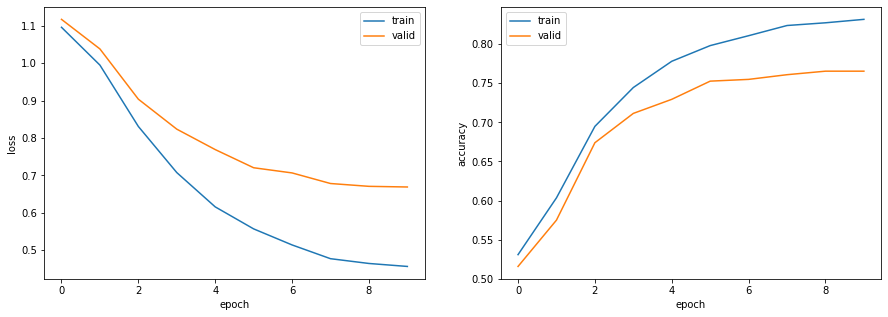

正解率（学習データ）：0.832
正解率（評価データ）：0.747


In [3]:
from torch.utils.data import DataLoader
import time
from torch import optim
import torch
from torch import nn
from torch.utils.data import Dataset
import pandas as pd
import string
import pickle
import numpy as np
from matplotlib import pyplot as plt
import torch

def tokenizer(text, word2id, unleg=0):
    """入力テキストをスペースで分割しID列に変換(辞書になければunlegで指定した数字を設定)"""
    table = str.maketrans(string.punctuation, " " * len(string.punctuation))
    res = []
    for word in text.translate(table).split():
        res.append(word2id.get(word, unleg))

    return res

class RNN(nn.Module):
    def __init__(self, vocab_size, emb_size, padding_idx, output_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
        self.rnn = nn.RNN(emb_size, hidden_size, nonlinearity="tanh", batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        self.batch_size = x.size()[0]
        hidden = self.init_hidden()  # h0のゼロベクトルを作成
        emb = self.emb(x)
        # emb.size() = (batch_size, seq_len, emb_size)
        out, hidden = self.rnn(emb, hidden)
        # out.size() = (batch_size, seq_len, hidden_size)
        out = self.fc(out[:, -1, :])
        # out.size() = (batch_size, output_size)
        return out

    def init_hidden(self):
        hidden = torch.zeros(1, self.batch_size, self.hidden_size, device=torch.device('cuda'))
        return hidden


class CreateDataset(Dataset):
    def __init__(self, X, y, tokenizer, word2id):
        self.X = X
        self.y = y
        self.tokenizer = tokenizer
        self.word2id = word2id

    def __len__(self):  # len(Dataset)で返す値を指定
        return len(self.y)

    def __getitem__(self, index):  # Dataset[index]で返す値を指定
        text = self.X[index]
        inputs = self.tokenizer(text, self.word2id)

        return {
            "inputs": torch.tensor(inputs, dtype=torch.int64),
            "labels": torch.tensor(self.y[index], dtype=torch.int64),
        }


def calculate_loss_and_accuracy(model, dataset, device=None, criterion=None):
    """損失・正解率を計算"""
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
    loss = 0.0
    total = 0
    correct = 0
    with torch.no_grad():
        for data in dataloader:
            # デバイスの指定
            inputs = data["inputs"].to(device)
            labels = data["labels"].to(device)

            # 順伝播
            outputs = model(inputs)

            # 損失計算
            if criterion != None:
                loss += criterion(outputs, labels).item()

            # 正解率計算
            pred = torch.argmax(outputs, dim=-1)
            total += len(inputs)
            correct += (pred == labels).sum().item()

    return loss / len(dataset), correct / total


def train_model(
    dataset_train,
    dataset_valid,
    batch_size,
    model,
    criterion,
    optimizer,
    num_epochs,
    collate_fn=None,
    device=None,
):
    """モデルの学習を実行し、損失・正解率のログを返す"""
    # デバイスの指定
    model.to(device)

    # dataloaderの作成
    dataloader_train = DataLoader(
        dataset_train, batch_size=batch_size, shuffle=True, collate_fn=collate_fn
    )
    dataloader_valid = DataLoader(dataset_valid, batch_size=1, shuffle=False)

    # スケジューラの設定
    scheduler = optim.lr_scheduler.CosineAnnealingLR(
        optimizer, num_epochs, eta_min=1e-5, last_epoch=-1
    )

    # 学習
    log_train = []
    log_valid = []
    for epoch in range(num_epochs):
        # 開始時刻の記録
        s_time = time.time()

        # 訓練モードに設定
        model.train()
        for data in dataloader_train:
            # 勾配をゼロで初期化
            optimizer.zero_grad()

            # 順伝播 + 誤差逆伝播 + 重み更新
            inputs = data["inputs"].to(device)
            labels = data["labels"].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # 評価モードに設定
        model.eval()

        # 損失と正解率の算出
        loss_train, acc_train = calculate_loss_and_accuracy(
            model, dataset_train, device, criterion=criterion
        )
        loss_valid, acc_valid = calculate_loss_and_accuracy(
            model, dataset_valid, device, criterion=criterion
        )
        log_train.append([loss_train, acc_train])
        log_valid.append([loss_valid, acc_valid])

        # チェックポイントの保存
        torch.save(
            {
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
            },
            f"checkpoint{epoch + 1}.pt",
        )

        # 終了時刻の記録
        e_time = time.time()

        # ログを出力
        print(
            f"epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec"
        )

        # 検証データの損失が3エポック連続で低下しなかった場合は学習終了
        if (
            epoch > 2
            and log_valid[epoch - 3][0]
            <= log_valid[epoch - 2][0]
            <= log_valid[epoch - 1][0]
            <= log_valid[epoch][0]
        ):
            break

        # スケジューラを1ステップ進める
        scheduler.step()

    return {"train": log_train, "valid": log_valid}


def visualize_logs(log):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(np.array(log["train"]).T[0], label="train")
    ax[0].plot(np.array(log["valid"]).T[0], label="valid")
    ax[0].set_xlabel("epoch")
    ax[0].set_ylabel("loss")
    ax[0].legend()
    ax[1].plot(np.array(log["train"]).T[1], label="train")
    ax[1].plot(np.array(log["valid"]).T[1], label="valid")
    ax[1].set_xlabel("epoch")
    ax[1].set_ylabel("accuracy")
    ax[1].legend()
    plt.show()


RNN, word2id, dataset_train, dataset_valid, dataset_test = unpickle(
    ["RNN", "word2id", "dataset_train", "dataset_valid", "dataset_test"]
)

# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
LEARNING_RATE = 1e-3
BATCH_SIZE = 1
NUM_EPOCHS = 10

# モデルの定義
model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

device = torch.device('cuda')

# モデルの学習
log = train_model(
    dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, device=device
)

with open('model.pkl', 'wb') as f:
  pickle.dump(model, f)

# ログの可視化
visualize_logs(log)

# 正解率の算出
_, acc_train = calculate_loss_and_accuracy(model, dataset_train, device=device)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test, device=device)
print(f"正解率（学習データ）：{acc_train:.3f}")
print(f"正解率（評価データ）：{acc_test:.3f}")


In [4]:
with open('model.pkl', 'rb') as f:
  model = pickle.load(f)

In [5]:
class Padsequence():
  """Dataloaderからミニバッチを取り出すごとに最大系列長でパディング"""
  def __init__(self, padding_idx):
    self.padding_idx = padding_idx

  def __call__(self, batch):
    sorted_batch = sorted(batch, key=lambda x: x['inputs'].shape[0], reverse=True)
    sequences = [x['inputs'] for x in sorted_batch]
    sequences_padded = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True, padding_value=self.padding_idx)
    labels = torch.LongTensor([x['labels'] for x in sorted_batch])

    return {'inputs': sequences_padded, 'labels': labels}

In [6]:
# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
LEARNING_RATE = 5e-2
BATCH_SIZE = 32
NUM_EPOCHS = 10

# モデルの定義
model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# デバイスの指定
device = torch.device('cuda:0')

# モデルの学習
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)

epoch: 1, loss_train: 1.2356, accuracy_train: 0.4115, loss_valid: 1.2368, accuracy_valid: 0.4048, 9.2409sec
epoch: 2, loss_train: 1.1853, accuracy_train: 0.4849, loss_valid: 1.2064, accuracy_valid: 0.4633, 9.3310sec
epoch: 3, loss_train: 1.0688, accuracy_train: 0.6042, loss_valid: 1.0819, accuracy_valid: 0.5870, 9.3091sec
epoch: 4, loss_train: 1.1629, accuracy_train: 0.5085, loss_valid: 1.1787, accuracy_valid: 0.4903, 9.3681sec
epoch: 5, loss_train: 1.1721, accuracy_train: 0.5077, loss_valid: 1.2030, accuracy_valid: 0.4963, 9.2766sec
epoch: 6, loss_train: 1.1816, accuracy_train: 0.4965, loss_valid: 1.2163, accuracy_valid: 0.4895, 9.3041sec


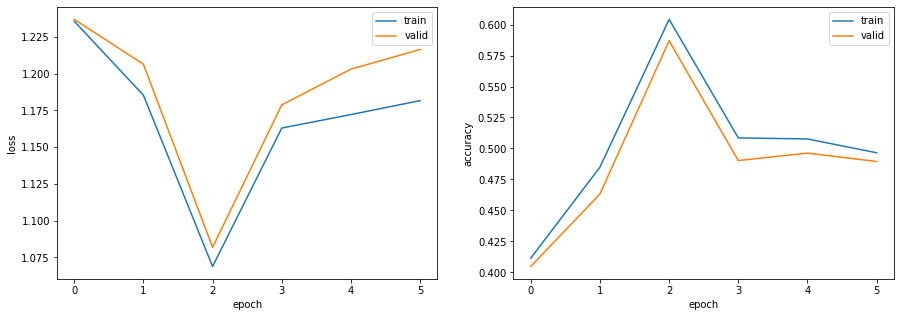

正解率（学習データ）：0.497
正解率（評価データ）：0.472


In [7]:
# ログの可視化
visualize_logs(log)

# 正解率の算出
_, acc_train = calculate_loss_and_accuracy(model, dataset_train, device)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test, device)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')

# 84

In [8]:
# 学習済み単語ベクトルのダウンロード
FILE_ID = "0B7XkCwpI5KDYNlNUTTlSS21pQmM"
FILE_NAME = "GoogleNews-vectors-negative300.bin.gz"
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=$FILE_ID' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=$FILE_ID" -O $FILE_NAME && rm -rf /tmp/cookies.txt

--2022-07-06 13:12:03--  https://docs.google.com/uc?export=download&confirm=t&id=0B7XkCwpI5KDYNlNUTTlSS21pQmM
Resolving docs.google.com (docs.google.com)... 142.251.12.139, 142.251.12.100, 142.251.12.102, ...
Connecting to docs.google.com (docs.google.com)|142.251.12.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0g-8s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/l0r96onidor0ciuo357731gccdjbb6v3/1657113075000/06848720943842814915/*/0B7XkCwpI5KDYNlNUTTlSS21pQmM?e=download&uuid=af86cc13-8522-4e20-b72b-c6234170e99e [following]
--2022-07-06 13:12:03--  https://doc-0g-8s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/l0r96onidor0ciuo357731gccdjbb6v3/1657113075000/06848720943842814915/*/0B7XkCwpI5KDYNlNUTTlSS21pQmM?e=download&uuid=af86cc13-8522-4e20-b72b-c6234170e99e
Resolving doc-0g-8s-docs.googleusercontent.com (doc-0g-8s-docs.googleusercontent.com)... 172.217.194.132, 2404:6800:4003

In [9]:
from gensim.models import KeyedVectors

# 学習済みモデルのロード
model = KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin.gz', binary=True)

# 学習済み単語ベクトルの取得
VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE = 300
weights = np.zeros((VOCAB_SIZE, EMB_SIZE))
words_in_pretrained = 0
for i, word in enumerate(word2id.keys()):
  try:
    weights[i] = model[word]
    words_in_pretrained += 1
  except KeyError:
    weights[i] = np.random.normal(scale=0.4, size=(EMB_SIZE,))
weights = torch.from_numpy(weights.astype((np.float32)))

print(f'学習済みベクトル利用単語数: {words_in_pretrained} / {VOCAB_SIZE}')
print(weights.size())

学習済みベクトル利用単語数: 9253 / 9502
torch.Size([9502, 300])


In [10]:
class RNN(nn.Module):
  def __init__(self, vocab_size, emb_size, padding_idx, output_size, hidden_size, num_layers, emb_weights=None, bidirectional=False):
    super().__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.num_directions = bidirectional + 1  # 単方向：1、双方向：2
    if emb_weights != None:  # 指定があれば埋め込み層の重みをemb_weightsで初期化
      self.emb = nn.Embedding.from_pretrained(emb_weights, padding_idx=padding_idx)
    else:
      self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
    self.rnn = nn.RNN(emb_size, hidden_size, num_layers, nonlinearity='tanh', bidirectional=bidirectional, batch_first=True)
    self.fc = nn.Linear(hidden_size * self.num_directions, output_size)

  def forward(self, x):
    self.batch_size = x.size()[0]
    hidden = self.init_hidden()  # h0のゼロベクトルを作成
    emb = self.emb(x)
    # emb.size() = (batch_size, seq_len, emb_size)
    out, hidden = self.rnn(emb, hidden)
    # out.size() = (batch_size, seq_len, hidden_size * num_directions)
    out = self.fc(out[:, -1, :])
    # out.size() = (batch_size, output_size)
    return out

  def init_hidden(self):
    hidden = torch.zeros(self.num_layers * self.num_directions, self.batch_size, self.hidden_size, device=torch.device('cuda'))
    return hidden

In [11]:
# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
NUM_LAYERS = 1
LEARNING_RATE = 5e-2
BATCH_SIZE = 32
NUM_EPOCHS = 10

# モデルの定義
model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, emb_weights=weights)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# デバイスの指定
device = torch.device('cuda')

# モデルの学習
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)

epoch: 1, loss_train: 1.1680, accuracy_train: 0.4312, loss_valid: 1.1679, accuracy_valid: 0.4445, 10.0034sec
epoch: 2, loss_train: 1.1149, accuracy_train: 0.5302, loss_valid: 1.1351, accuracy_valid: 0.5150, 9.4799sec
epoch: 3, loss_train: 1.0623, accuracy_train: 0.5889, loss_valid: 1.0741, accuracy_valid: 0.5675, 9.5071sec
epoch: 4, loss_train: 1.0363, accuracy_train: 0.6105, loss_valid: 1.0335, accuracy_valid: 0.6244, 9.4225sec
epoch: 5, loss_train: 1.2234, accuracy_train: 0.4969, loss_valid: 1.2634, accuracy_valid: 0.4843, 9.3737sec
epoch: 6, loss_train: 0.9795, accuracy_train: 0.6596, loss_valid: 0.9947, accuracy_valid: 0.6372, 9.3494sec
epoch: 7, loss_train: 0.9768, accuracy_train: 0.6451, loss_valid: 1.0027, accuracy_valid: 0.6207, 9.4760sec
epoch: 8, loss_train: 0.9626, accuracy_train: 0.6503, loss_valid: 0.9830, accuracy_valid: 0.6259, 9.4585sec
epoch: 9, loss_train: 0.9282, accuracy_train: 0.6695, loss_valid: 0.9458, accuracy_valid: 0.6432, 9.3459sec
epoch: 10, loss_train: 0.95

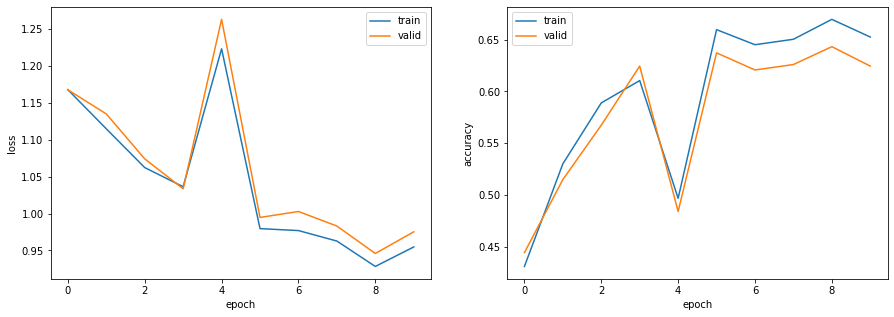

正解率（学習データ）：0.652
正解率（評価データ）：0.627


In [12]:
# ログの可視化
visualize_logs(log)

# 正解率の算出
_, acc_train = calculate_loss_and_accuracy(model, dataset_train, device)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test, device)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')

# 85

In [13]:
# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
NUM_LAYERS = 2
LEARNING_RATE = 5e-2
BATCH_SIZE = 32
NUM_EPOCHS = 10

# モデルの定義
model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, emb_weights=weights, bidirectional=True)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# デバイスの指定
device = torch.device('cuda')

# モデルの学習
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)

epoch: 1, loss_train: 1.1631, accuracy_train: 0.4533, loss_valid: 1.1625, accuracy_valid: 0.4693, 13.6993sec
epoch: 2, loss_train: 1.0890, accuracy_train: 0.5494, loss_valid: 1.1081, accuracy_valid: 0.5450, 13.7029sec
epoch: 3, loss_train: 1.1485, accuracy_train: 0.5022, loss_valid: 1.1657, accuracy_valid: 0.4985, 14.6969sec
epoch: 4, loss_train: 1.0557, accuracy_train: 0.5829, loss_valid: 1.0726, accuracy_valid: 0.5720, 13.8353sec
epoch: 5, loss_train: 1.0692, accuracy_train: 0.5723, loss_valid: 1.0990, accuracy_valid: 0.5645, 13.6677sec
epoch: 6, loss_train: 0.9625, accuracy_train: 0.6412, loss_valid: 0.9745, accuracy_valid: 0.6259, 13.7381sec
epoch: 7, loss_train: 0.9502, accuracy_train: 0.6436, loss_valid: 0.9687, accuracy_valid: 0.6349, 13.6840sec
epoch: 8, loss_train: 0.9511, accuracy_train: 0.6433, loss_valid: 0.9745, accuracy_valid: 0.6372, 13.7239sec
epoch: 9, loss_train: 0.9285, accuracy_train: 0.6534, loss_valid: 0.9454, accuracy_valid: 0.6439, 13.6639sec
epoch: 10, loss_tra

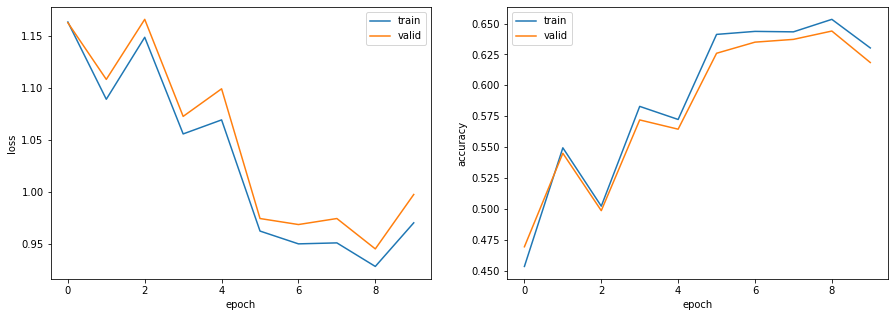

正解率（学習データ）：0.630
正解率（評価データ）：0.609


In [14]:
# ログの可視化
visualize_logs(log)

# 正解率の算出
_, acc_train = calculate_loss_and_accuracy(model, dataset_train, device)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test, device)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')

# 86

In [ ]:
from torch.nn import functional as F

class CNN(nn.Module):
  def __init__(self, vocab_size, emb_size, padding_idx, output_size, out_channels, kernel_heights, stride, padding, emb_weights=None):
    super().__init__()
    if emb_weights != None:  # 指定があれば埋め込み層の重みをemb_weightsで初期化
      self.emb = nn.Embedding.from_pretrained(emb_weights, padding_idx=padding_idx)
    else:
      self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
    self.conv = nn.Conv2d(1, out_channels, (kernel_heights, emb_size), stride, (padding, 0))
    self.drop = nn.Dropout(0.3) # 過剰適合を防ぐ(30%のユニット削除)
    self.fc = nn.Linear(out_channels, output_size)

  def forward(self, x):
    '''埋め込み->畳み込み->relu->maxプーリング->全結合'''
    # x.size() = (batch_size, seq_len)
    emb = self.emb(x).unsqueeze(1)
    # emb.size() = (batch_size, 1, seq_len, emb_size)
    conv = self.conv(emb)
    # conv.size() = (batch_size, out_channels, seq_len, 1)
    act = F.relu(conv.squeeze(3))
    # act.size() = (batch_size, out_channels, seq_len)
    max_pool = F.max_pool1d(act, act.size()[2])
    # max_pool.size() = (batch_size, out_channels, 1) -> seq_len方向に最大値を取得
    out = self.fc(self.drop(max_pool.squeeze(2)))
    # out.size() = (batch_size, output_size)
    return out

: 

In [ ]:
# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1  # paddingする分追加
EMB_SIZE = 300
PADDING_IDX = 0
OUTPUT_SIZE = 4
OUT_CHANNELS = 100
KERNEL_HEIGHTS = 3
STRIDE = 1
PADDING = 1

# モデルの定義
model = CNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, OUT_CHANNELS, KERNEL_HEIGHTS, STRIDE, PADDING, emb_weights=weights)

# 先頭10件の予測値取得
for i in range(10):
  X = dataset_train[i]['inputs']
  print(torch.softmax(model(X.unsqueeze(0)), dim=-1))

: 

# 87

In [17]:
# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
OUT_CHANNELS = 100
KERNEL_HEIGHTS = 3
STRIDE = 1
PADDING = 1
LEARNING_RATE = 5e-2
BATCH_SIZE = 64
NUM_EPOCHS = 10

# モデルの定義
model = CNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, OUT_CHANNELS, KERNEL_HEIGHTS, STRIDE, PADDING, emb_weights=weights)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# デバイスの指定
device = torch.device('cuda')

# モデルの学習
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)

epoch: 1, loss_train: 1.0775, accuracy_train: 0.5616, loss_valid: 1.0795, accuracy_valid: 0.5855, 9.3255sec
epoch: 2, loss_train: 1.0047, accuracy_train: 0.6194, loss_valid: 1.0137, accuracy_valid: 0.6334, 8.7811sec
epoch: 3, loss_train: 0.9290, accuracy_train: 0.6791, loss_valid: 0.9489, accuracy_valid: 0.6784, 8.7583sec
epoch: 4, loss_train: 0.8690, accuracy_train: 0.7106, loss_valid: 0.9030, accuracy_valid: 0.6942, 8.7918sec
epoch: 5, loss_train: 0.8246, accuracy_train: 0.7236, loss_valid: 0.8689, accuracy_valid: 0.7091, 8.7978sec
epoch: 6, loss_train: 0.7939, accuracy_train: 0.7329, loss_valid: 0.8436, accuracy_valid: 0.7129, 8.7860sec
epoch: 7, loss_train: 0.7733, accuracy_train: 0.7381, loss_valid: 0.8299, accuracy_valid: 0.7166, 8.8376sec
epoch: 8, loss_train: 0.7613, accuracy_train: 0.7429, loss_valid: 0.8233, accuracy_valid: 0.7189, 8.8360sec
epoch: 9, loss_train: 0.7556, accuracy_train: 0.7445, loss_valid: 0.8190, accuracy_valid: 0.7211, 8.8174sec
epoch: 10, loss_train: 0.754

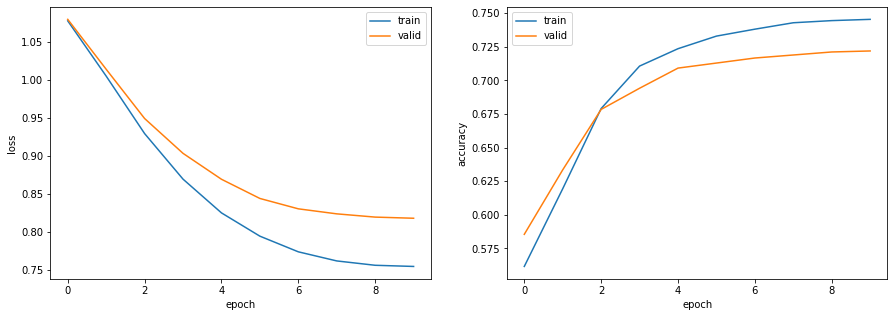

正解率（学習データ）：0.745
正解率（評価データ）：0.702


In [18]:
# ログの可視化
visualize_logs(log)

# 正解率の算出
_, acc_train = calculate_loss_and_accuracy(model, dataset_train, device)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test, device)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')

# 88

In [19]:
from torch.nn import functional as F

class textCNN(nn.Module):
  def __init__(self, vocab_size, emb_size, padding_idx, output_size, out_channels, conv_params, drop_rate, emb_weights=None):
    super().__init__()
    if emb_weights != None:  # 指定があれば埋め込み層の重みをemb_weightsで初期化
      self.emb = nn.Embedding.from_pretrained(emb_weights, padding_idx=padding_idx)
    else:
      self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
    self.convs = nn.ModuleList([nn.Conv2d(1, out_channels, (kernel_height, emb_size), padding=(padding, 0)) for kernel_height, padding in conv_params])
    self.drop = nn.Dropout(drop_rate)
    self.fc = nn.Linear(len(conv_params) * out_channels, output_size)

  def forward(self, x):
    # x.size() = (batch_size, seq_len)
    emb = self.emb(x).unsqueeze(1)
    # emb.size() = (batch_size, 1, seq_len, emb_size)
    conv = [F.relu(conv(emb)).squeeze(3) for i, conv in enumerate(self.convs)]
    # conv[i].size() = (batch_size, out_channels, seq_len + padding * 2 - kernel_height + 1)
    max_pool = [F.max_pool1d(i, i.size(2)) for i in conv]
    # max_pool[i].size() = (batch_size, out_channels, 1) -> seq_len方向に最大値を取得
    max_pool_cat = torch.cat(max_pool, 1)
    # max_pool_cat.size() = (batch_size, len(conv_params) * out_channels, 1)  -> フィルター別の結果を結合
    out = self.fc(self.drop(max_pool_cat.squeeze(2)))
    # out.size() = (batch_size, output_size)
    return out

In [20]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [21]:
import optuna

def objective(trial):
  # チューニング対象パラメータのセット
  emb_size = int(trial.suggest_discrete_uniform('emb_size', 100, 400, 100))
  out_channels = int(trial.suggest_discrete_uniform('out_channels', 50, 200, 50))
  drop_rate = trial.suggest_discrete_uniform('drop_rate', 0.0, 0.5, 0.1)
  learning_rate = trial.suggest_loguniform('learning_rate', 5e-4, 5e-2)
  momentum = trial.suggest_discrete_uniform('momentum', 0.5, 0.9, 0.1)
  batch_size = int(trial.suggest_discrete_uniform('batch_size', 16, 128, 16))

  # 固定パラメータの設定
  VOCAB_SIZE = len(set(word2id.values())) + 1
  PADDING_IDX = len(set(word2id.values()))
  OUTPUT_SIZE = 4
  CONV_PARAMS = [[2, 0], [3, 1], [4, 2]]
  NUM_EPOCHS = 30

  # モデルの定義
  model = textCNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, out_channels, CONV_PARAMS, drop_rate, emb_weights=weights)

  # 損失関数の定義
  criterion = nn.CrossEntropyLoss()

  # オプティマイザの定義
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

  # デバイスの指定
  device = torch.device('cuda')

  # モデルの学習
  log = train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)

  # 損失の算出
  loss_valid, _ = calculate_loss_and_accuracy(model, dataset_valid, device, criterion=criterion) 

  return loss_valid 

In [42]:
# 最適化
study = optuna.create_study()
study.optimize(objective, timeout=7200)

# 結果の表示
print('Best trial:')
trial = study.best_trial
print('  Value: {:.3f}'.format(trial.value))
print('  Params: ')
for key, value in trial.params.items():
  print('    {}: {}'.format(key, value))

[I 2022-07-06 13:40:00,688] A new study created in memory with name: no-name-decb7a45-f2cb-46a7-a8d8-1bc05ae23626
[W 2022-07-06 13:40:00,700] Trial 0 failed because of the following error: TypeError("train_model() got an unexpected keyword argument 'collate_fn'")
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/optuna/study/_optimize.py", line 213, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-21-2ca03097a095>", line 32, in objective
    log = train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)
TypeError: train_model() got an unexpected keyword argument 'collate_fn'


TypeError: ignored

# 89

In [23]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [24]:
import transformers
from transformers import BertTokenizer, BertModel
import time
from torch import cuda

In [25]:
# Datasetの定義
class CreateDataset(Dataset):
  def __init__(self, X, y, tokenizer, max_len):
    self.X = X
    self.y = y
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):  # len(Dataset)で返す値を指定
    return len(self.y)

  def __getitem__(self, index):  # Dataset[index]で返す値を指定
    text = self.X[index]
    inputs = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_len,
      pad_to_max_length=True
    )
    ids = inputs['input_ids']
    mask = inputs['attention_mask']

    return {
      'ids': torch.LongTensor(ids),
      'mask': torch.LongTensor(mask),
      'labels': torch.Tensor(self.y[index])
    }

In [26]:
train = pd.read_csv("train.txt", sep="\t")
valid = pd.read_csv("valid.txt", sep="\t")
test = pd.read_csv("test.txt", sep="\t")

# 正解ラベルのone-hot化
y_train = pd.get_dummies(train, columns=['CATEGORY'])[['CATEGORY_b', 'CATEGORY_e', 'CATEGORY_t', 'CATEGORY_m']].values
y_valid = pd.get_dummies(valid, columns=['CATEGORY'])[['CATEGORY_b', 'CATEGORY_e', 'CATEGORY_t', 'CATEGORY_m']].values
y_test = pd.get_dummies(test, columns=['CATEGORY'])[['CATEGORY_b', 'CATEGORY_e', 'CATEGORY_t', 'CATEGORY_m']].values

# Datasetの作成
max_len = 20
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
dataset_train = CreateDataset(train['TITLE'], y_train, tokenizer, max_len)
dataset_valid = CreateDataset(valid['TITLE'], y_valid, tokenizer, max_len)
dataset_test = CreateDataset(test['TITLE'], y_test, tokenizer, max_len)

for var in dataset_train[0]:
  print(f'{var}: {dataset_train[0][var]}')

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


ids: tensor([  101, 13371,  1011, 10651,  1021,  1011, 12895, 13587,  4212,  2153,
         2004,  5712,  4425, 10069,  7496,   102,     0,     0,     0,     0])
mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0])
labels: tensor([1., 0., 0., 0.])


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [27]:
# BERT分類モデルの定義
class BERTClass(torch.nn.Module):
  def __init__(self, drop_rate, otuput_size):
    super().__init__()
    self.bert = BertModel.from_pretrained('bert-base-uncased')
    self.drop = torch.nn.Dropout(drop_rate)
    self.fc = torch.nn.Linear(768, otuput_size)  # BERTの出力に合わせて768次元を指定

  def forward(self, ids, mask):
    _, out = self.bert(ids, attention_mask=mask)
    out = self.fc(self.drop(out))
    return out

In [28]:
def calculate_loss_and_accuracy(model, criterion, loader, device):
  """ 損失・正解率を計算"""
  model.eval()
  loss = 0.0
  total = 0
  correct = 0
  with torch.no_grad():
    for data in loader:
      # デバイスの指定
      ids = data['ids'].to(device)
      mask = data['mask'].to(device)
      labels = data['labels'].to(device)

      # 順伝播
      outputs = model(ids, mask)

      # 損失計算
      loss += criterion(outputs, labels).item()

      # 正解率計算
      pred = torch.argmax(outputs, dim=-1).cpu().numpy() # バッチサイズの長さの予測ラベル配列
      labels = torch.argmax(labels, dim=-1).cpu().numpy()  # バッチサイズの長さの正解ラベル配列
      total += len(labels)
      correct += (pred == labels).sum().item()

  return loss / len(loader), correct / total


def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, device=None):
  """モデルの学習を実行し、損失・正解率のログを返す"""
  # デバイスの指定
  model.to(device)

  # dataloaderの作成
  dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
  dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)

  # 学習
  log_train = []
  log_valid = []
  for epoch in range(num_epochs):
    # 開始時刻の記録
    s_time = time.time()

    # 訓練モードに設定
    model.train()
    for data in dataloader_train:
      # デバイスの指定
      ids = data['ids'].to(device)
      mask = data['mask'].to(device)
      labels = data['labels'].to(device)

      # 勾配をゼロで初期化
      optimizer.zero_grad()

      # 順伝播 + 誤差逆伝播 + 重み更新
      outputs = model(ids, mask)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

    # 損失と正解率の算出
    loss_train, acc_train = calculate_loss_and_accuracy(model, criterion, dataloader_train, device)
    loss_valid, acc_valid = calculate_loss_and_accuracy(model, criterion, dataloader_valid, device)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])

    # チェックポイントの保存
    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

    # 終了時刻の記録
    e_time = time.time()

    # ログを出力
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec') 

  return {'train': log_train, 'valid': log_valid}

In [ ]:
%env CUDA_LAUNCH_BLOCKING = 1
%env

In [41]:
# パラメータの設定
DROP_RATE = 0.4
OUTPUT_SIZE = 4
BATCH_SIZE = 32
NUM_EPOCHS = 4
LEARNING_RATE = 2e-5

# モデルの定義
model = BERTClass(DROP_RATE, OUTPUT_SIZE)

# 損失関数の定義
criterion = torch.nn.BCEWithLogitsLoss()

# オプティマイザの定義
optimizer = torch.optim.AdamW(params=model.parameters(), lr=LEARNING_RATE)

# デバイスの指定
device = 'cuda'

# モデルの学習
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, device=device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


RuntimeError: ignored